In [1]:
%matplotlib notebook
import math
import matplotlib.pyplot as plt
import numpy as np
import quaternion
import pandas
import sys

from algorithms import geometry
from pre_processing import gen_dataset
from utility import write_trajectory_to_ply
from scipy.ndimage.filters import gaussian_filter1d
nano_to_sec = 1e09

# configure the size of plot
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 12
fig_size[1] = 9

In [2]:
def orientation_from_gravity_and_magnet(grav, magnet,
                                        global_gravity=np.array([0, 0, 1]),
                                        global_north=np.array([0, 1, 0])):
    rot_grav = geometry.quaternion_from_two_vectors(grav, global_gravity)
    # remove tilting
    magnet_grav = (rot_grav * quaternion.quaternion(1.0, *magnet) * rot_grav.conj()).vec
    magnet_grav[2] = 0.0
    rot_magnet = geometry.quaternion_from_two_vectors(magnet_grav, global_north)
    return rot_magnet * rot_grav

In [26]:
a = -0.98
2 * a * a - 1.0

0.9207999999999998

In [5]:
# complmentary filter
def correct_gyro_drifting(rv, magnet, gravity, alpha=0.9999,
                          min_cos = 0.8, mag_range=(30, 55),
                          global_orientation=None):
    assert rv.shape[0] == magnet.shape[0]
    assert rv.shape[0] == gravity.shape[0]
    
    rv_quats = []
    for r in rv:
        rv_quats.append(quaternion.quaternion(*r))
    if global_orientation is None:
        global_orientation = rv_quats[0]
    
    mag_mag = np.linalg.norm(magnet, axis=1)
    # fake the angular velocity by differentiating the rotation vector
    rv_dif = [quaternion.quaternion(1.0, 0.0, 0.0, 0.0) for _ in range(rv.shape[0])]
    for i in range(1, rv.shape[0]):
        rv_dif[i] = rv_quats[i] * rv_quats[i-1].inverse()
        
    # complementary filter
    rv_filtered = [global_orientation for _ in range(rv.shape[0])]
    rv_mag_init_trans = global_orientation * orientation_from_gravity_and_magnet(magnet[0], gravity[0]).conj()
    fused = [0 for _ in range(rv.shape[0])]
    for i in range(1, rv.shape[0]):
        # from gyroscop
        rv_filtered[i] = rv_dif[i] * rv_filtered[i - 1]
        # if the magnitude of the magnet field is unreasonable, skip
        if mag_mag[i]< mag_range[0] or mag_mag[i] > mag_range[1]:
            continue
        # from magnetometer
        rv_mag = rv_mag_init_trans * orientation_from_gravity_and_magnet(magnet[i], gravity[i])
        diff_angle = rv_filtered[i].conj() * rv_mag
        diff_angle_cos = 2 * diff_angle.w * diff_angle.w - 1.0
        # only fuse when the magnetometer is "reasonable"
        fused[i] = diff_angle_cos
        if diff_angle_cos >= min_cos:
            rv_filtered[i] = quaternion.slerp(rv_filtered[i], rv_mag, 0.0, 1.0, 1.0 - alpha)
    return quaternion.as_float_array(rv_filtered), fused
    

In [4]:
def plot_trajectory(position, orientation, name, interval=100, length=1.0, c='b'):
    assert position.shape[0] == orientation.shape[0]
    plt.figure(name)
    plt.plot(position[:, 0], position[:, 1], color='r')
    
    local_x = quaternion.quaternion(1.0, length, 0.0, 0.0)
    for i in range(0, position.shape[0], interval):
        q = quaternion.quaternion(*orientation[i])
        global_x = (q * local_x * q.conj()).vec
        vtx = np.array([position[i], position[i] + global_x])
        plt.plot(vtx[:, 0], vtx[:, 1], color=c)

<IPython.core.display.Javascript object>


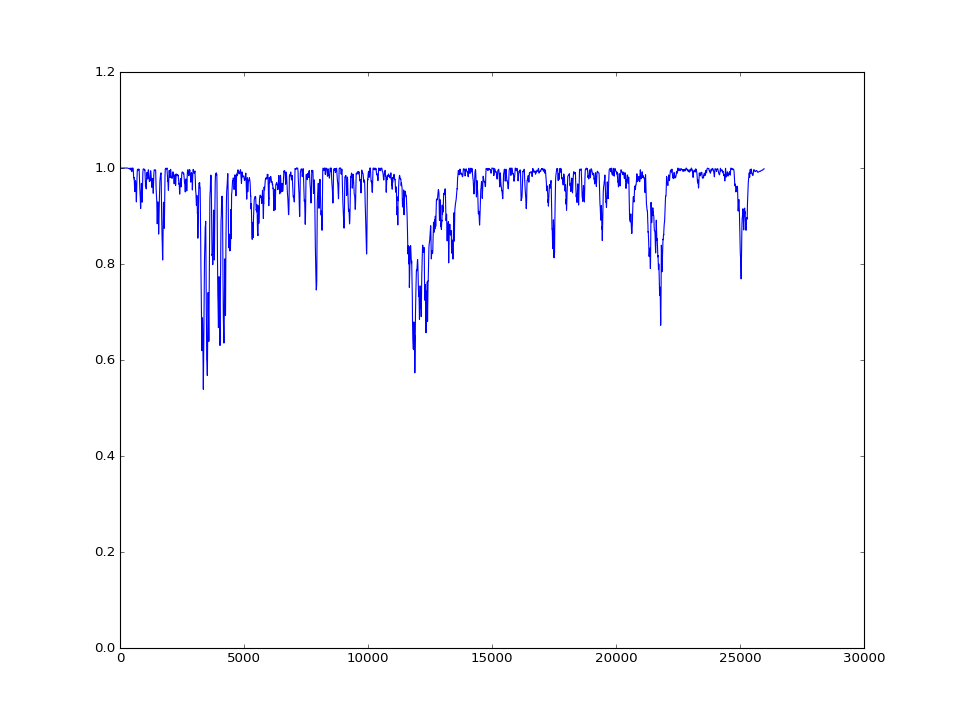

<IPython.core.display.Javascript object>


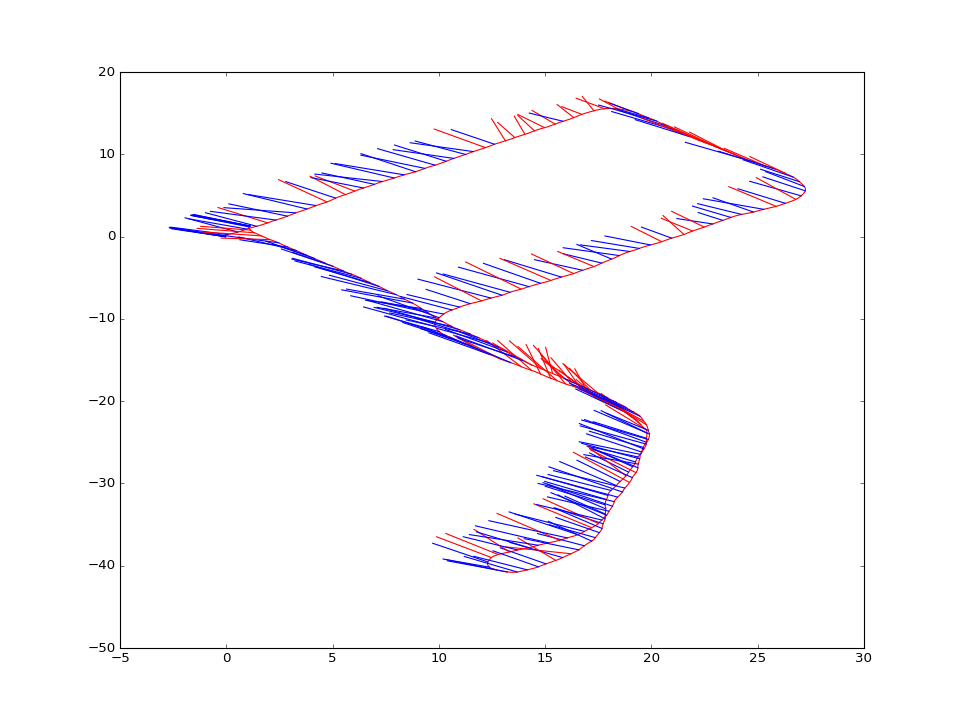

<IPython.core.display.Javascript object>


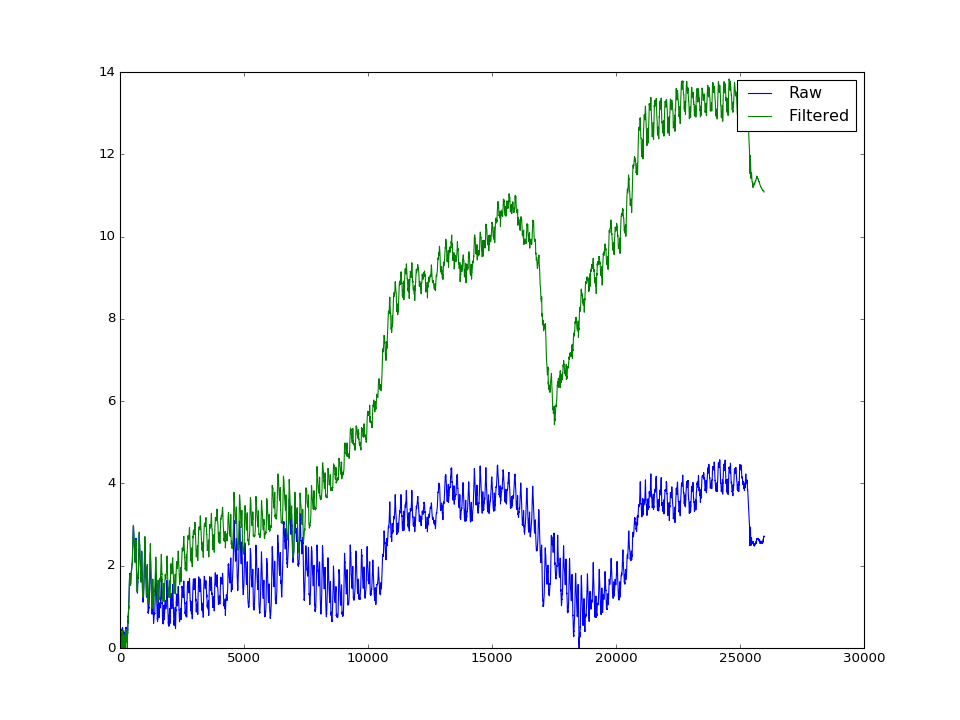

In [8]:
data_path = '../../data2/huayi_leg2'
data_all = pandas.read_csv(data_path + '/processed/data.csv')

magnet_data = np.genfromtxt(data_path + '/magnet.txt')
ts = data_all['time'].values
magnet = data_all[['magnet_x', 'magnet_y', 'magnet_z']].values
orientation = data_all[['ori_w', 'ori_x', 'ori_y', 'ori_z']].values
position = data_all[['pos_x', 'pos_y', 'pos_z']].values
gravity = data_all[['grav_x', 'grav_y', 'grav_z']].values

magnet = gaussian_filter1d(magnet, sigma=20, axis=0)
# magnet_grav = geometry.align_3dvector_with_gravity(magnet, gravity)
# # magnet_grav = magnet
# magnet_center = (np.max(magnet_grav, axis=0) + np.min(magnet_grav, axis=0)) / 2

# plt.figure('raw magnet')
# for i in [0, 2]:
#     plt.plot(magnet_grav[:, i])
# plt.legend(['x', 'z'])

magnet_rotated = np.empty(magnet.shape)
for i in range(magnet.shape[0]):
    q = quaternion.quaternion(*orientation[i])
    magnet_rotated[i] = (q * quaternion.quaternion(0.0, *magnet[i]) * q.conj()).vec

# magnet = gaussian_filter1d(magnet, sigma=2.0, axis=0)
magnet_mag = np.linalg.norm(magnet, axis=1)
max_mag = np.max(magnet_mag)
# plt.figure('magnet magnitude')
# plt.plot(magnet_mag)

# mag_error = np.empty(magnet.shape[0])
# ref = magnet[0, :2] / np.linalg.norm(magnet[0, :2])
# for i in range(magnet.shape[0]):
#     mag_error[i] = 1.0 - np.dot(magnet[i, :2], ref) / np.linalg.norm(magnet[i, :2])

# ori_from_magnet = []
# for i in range(ts.shape[0]):
#     ori_from_magnet.append(orientation_from_gravity_and_magnet(gravity[i], magnet[i]))
# ori_mag_init = quaternion.quaternion(*orientation[0]) * ori_from_magnet[0].inverse()
# for i in range(ts.shape[0]):
#     ori_from_magnet[i] = ori_mag_init * ori_from_magnet[i]

# write_trajectory_to_ply.write_ply_to_file(data_path + '/processed/ori_grav_magnet.ply', position, 
#                                           quaternion.as_float_array(ori_from_magnet),
#                                           acceleration=gravity,
#                                           interval=200, length=5.0)

# plot_trajectory(position, quaternion.as_float_array(ori_from_magnet), 'orientation', interval=200, length=3.0)

# test with complmentary filter
rv = data_all[['rv_w', 'rv_x', 'rv_y', 'rv_z']].values
rv_init = quaternion.quaternion(*orientation[0]) * quaternion.quaternion(*rv[0]).conj()
for i in range(rv.shape[0]):
    rv[i] = quaternion.as_float_array(rv_init * quaternion.quaternion(*rv[i]))

min_cos = 0.95
rv_filtered, fused = correct_gyro_drifting(rv, magnet, gravity, alpha=0.9999, min_cos=min_cos,
                                           mag_range=(25, 65),
                                           global_orientation=quaternion.quaternion(*orientation[0]))

# plot_trajectory(position, orientation, 'orientation', interval=200, length=3.0, c='g')

plt.figure('angle')
plt.plot(fused)

# write_trajectory_to_ply.write_ply_to_file(data_path + '/processed/comp_filter.ply', position, rv_filtered,
#                                           acceleration=gravity,
#                                           interval=200)

plt.figure('Magnet direction')
plt.plot(position[0:-1:10, 0], position[0:-1:10, 1], color='r')

interval = 100
mag_ratio = 10.0 / max_mag
for i in range(0, position.shape[0], interval):
    vtx = np.array([position[i, :2], position[i, :2] + magnet_rotated[i, :2] * mag_ratio])
    if fused[i] < min_cos:
        plt.plot(vtx[:, 0], vtx[:, 1], color='r')
    else:
        plt.plot(vtx[:, 0], vtx[:, 1], color='b')

error_raw = np.empty(orientation.shape[0], dtype=float)
error_filtered = np.empty(orientation.shape[0], dtype=float)
for i in range(orientation.shape[0]):
    e = quaternion.quaternion(*rv[i]).conj()* quaternion.quaternion(*orientation[i])
    error_raw[i] = math.degrees(math.acos(min(max(2 * e.w * e.w - 1.0, -1.0), 1.0)))
    e = quaternion.quaternion(*rv_filtered[i]).conj()* quaternion.quaternion(*orientation[i])
    error_filtered[i] = math.degrees(math.acos(min(max(2 * e.w * e.w - 1.0, -1.0), 1.0)))

plt.figure("Angular error")
plt.plot(error_raw)
plt.plot(error_filtered)
plt.legend(['Raw', 'Filtered'])